In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    Resized,
    RandAffined,
    RandRotate90d,
    RandZoomd,
    RandFlipd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet, SwinUNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np
from tqdm.notebook import tqdm

In [2]:
data_dir = "Task06_Lung/"

train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-13], data_dicts[-13:]

print(f"length of train_files: {len(train_files)}, val_files: {len(val_files)}")

length of train_files: 50, val_files: 13


In [3]:
set_determinism(seed=42)

In [4]:
"""
# Find intensity value range from train dataset
import nibabel as nib
def find_min_max_intensity_nifti(dataset_path):
    min_intensity = float('inf')
    max_intensity = float('-inf')

    # Assuming MRI images are stored as NIfTI files (.nii or .nii.gz)
    for file_name in os.listdir(dataset_path):
        if file_name.endswith('.nii') or file_name.endswith('.nii.gz'):
            file_path = os.path.join(dataset_path, file_name)
            
            # Load the MRI image using NiBabel
            img = nib.load(file_path)
            data = img.get_fdata()

            # Find the min and max intensity values in the image
            current_min = data.min()
            current_max = data.max()

            # Update overall min and max intensity values
            min_intensity = min(min_intensity, current_min)
            max_intensity = max(max_intensity, current_max)

    return min_intensity, max_intensity

# Replace 'your_dataset_path' with the actual path to your NIfTI dataset
nifti_dataset_path = 'Task02_Heart/imagesTr'
min_intensity_nifti, max_intensity_nifti = find_min_max_intensity_nifti(nifti_dataset_path)

print(f"Minimum intensity: {min_intensity_nifti}")
print(f"Maximum intensity: {max_intensity_nifti}")
"""

""""""

''

In [5]:
train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=(96, 96, 96),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)
        ),
        #RandRotate90d(keys=['image', 'label'], prob=0.5),
        #RandZoomd(keys=['image', 'label'], min_zoom=0.9, max_zoom=1.1, prob=0.5),
        #RandFlipd(keys=['image', 'label'], prob=0.5)
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


image shape: torch.Size([214, 203, 185]), label shape: torch.Size([214, 203, 185])


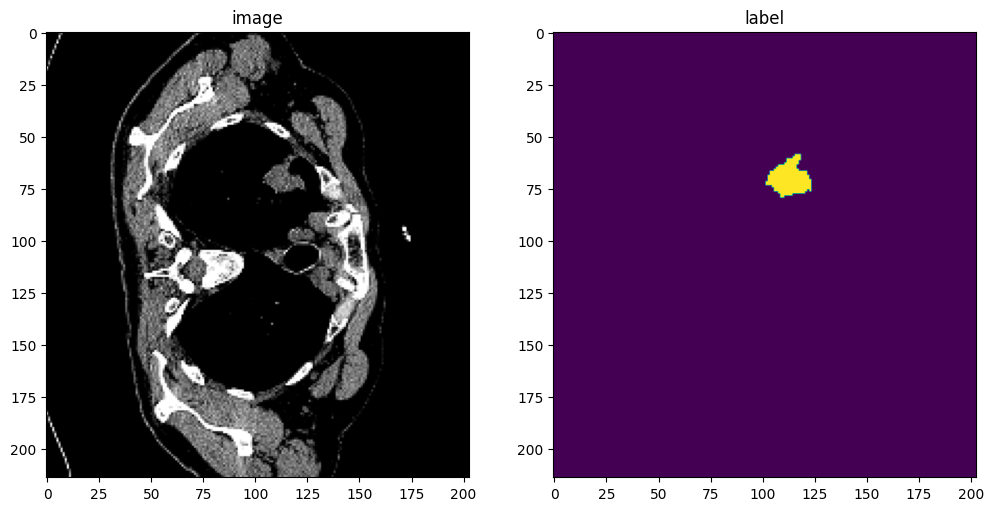

In [6]:
# Check dataset

view_ds = Dataset(data=val_files, transform=val_transform)
view_loader = DataLoader(view_ds, batch_size=1)

view_data = first(view_loader)

image, label = (view_data["image"][0][0], view_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

view_slice = 150

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, view_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, view_slice])
plt.show()


In [7]:
train_ds = CacheDataset(data=train_files, transform=train_transform, cache_rate=1.0, num_workers=12)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=12)

val_ds = CacheDataset(data=val_files, transform=val_transform, cache_rate=1.0, num_workers=12)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=12)

Loading dataset: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
"""
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

"""

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.INSTANCE,
).to(device)

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=2,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=True, reduction="mean")

In [9]:
num_epochs = 1000
val_interval = 5
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(num_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{num_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in tqdm(train_loader):
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        #print(inputs.shape)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        #print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_images, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]

                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            metric_values.append(metric)
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 1 average loss: 1.2840
----------
epoch 2/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 2 average loss: 1.1935
----------
epoch 3/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 3 average loss: 1.1361
----------
epoch 4/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 4 average loss: 1.0824
----------
epoch 5/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 5 average loss: 1.0283
saved new best metric model
current epoch: 5 current mean dice: 0.4987
best mean dice: 0.4987 at epoch: 5
----------
epoch 6/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 6 average loss: 0.9823
----------
epoch 7/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 7 average loss: 0.9414
----------
epoch 8/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 8 average loss: 0.9039
----------
epoch 9/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 9 average loss: 0.8706
----------
epoch 10/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 10 average loss: 0.8405
saved new best metric model
current epoch: 10 current mean dice: 0.4999
best mean dice: 0.4999 at epoch: 10
----------
epoch 11/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 11 average loss: 0.8133
----------
epoch 12/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 12 average loss: 0.7898
----------
epoch 13/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 13 average loss: 0.7670
----------
epoch 14/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 14 average loss: 0.7464
----------
epoch 15/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 15 average loss: 0.7288
saved new best metric model
current epoch: 15 current mean dice: 0.5005
best mean dice: 0.5005 at epoch: 15
----------
epoch 16/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 16 average loss: 0.7109
----------
epoch 17/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 17 average loss: 0.6972
----------
epoch 18/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 18 average loss: 0.6839
----------
epoch 19/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 19 average loss: 0.6718
----------
epoch 20/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 20 average loss: 0.6572
current epoch: 20 current mean dice: 0.5001
best mean dice: 0.5005 at epoch: 15
----------
epoch 21/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 21 average loss: 0.6490
----------
epoch 22/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 22 average loss: 0.6377
----------
epoch 23/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 23 average loss: 0.6270
----------
epoch 24/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 24 average loss: 0.6183
----------
epoch 25/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 25 average loss: 0.6115
saved new best metric model
current epoch: 25 current mean dice: 0.5276
best mean dice: 0.5276 at epoch: 25
----------
epoch 26/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 26 average loss: 0.6050
----------
epoch 27/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 27 average loss: 0.6018
----------
epoch 28/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 28 average loss: 0.5888
----------
epoch 29/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 29 average loss: 0.5871
----------
epoch 30/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 30 average loss: 0.5795
current epoch: 30 current mean dice: 0.5211
best mean dice: 0.5276 at epoch: 25
----------
epoch 31/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 31 average loss: 0.5670
----------
epoch 32/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 32 average loss: 0.5649
----------
epoch 33/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 33 average loss: 0.5636
----------
epoch 34/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 34 average loss: 0.5552
----------
epoch 35/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 35 average loss: 0.5545
saved new best metric model
current epoch: 35 current mean dice: 0.5318
best mean dice: 0.5318 at epoch: 35
----------
epoch 36/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 36 average loss: 0.5506
----------
epoch 37/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 37 average loss: 0.5429
----------
epoch 38/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 38 average loss: 0.5349
----------
epoch 39/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 39 average loss: 0.5326
----------
epoch 40/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 40 average loss: 0.5298
current epoch: 40 current mean dice: 0.5203
best mean dice: 0.5318 at epoch: 35
----------
epoch 41/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 41 average loss: 0.5315
----------
epoch 42/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 42 average loss: 0.5227
----------
epoch 43/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 43 average loss: 0.5182
----------
epoch 44/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 44 average loss: 0.5122
----------
epoch 45/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 45 average loss: 0.5142
saved new best metric model
current epoch: 45 current mean dice: 0.5605
best mean dice: 0.5605 at epoch: 45
----------
epoch 46/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 46 average loss: 0.5098
----------
epoch 47/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 47 average loss: 0.5055
----------
epoch 48/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 48 average loss: 0.5054
----------
epoch 49/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 49 average loss: 0.5107
----------
epoch 50/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 50 average loss: 0.4980
current epoch: 50 current mean dice: 0.5550
best mean dice: 0.5605 at epoch: 45
----------
epoch 51/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 51 average loss: 0.5027
----------
epoch 52/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 52 average loss: 0.4909
----------
epoch 53/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 53 average loss: 0.4882
----------
epoch 54/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 54 average loss: 0.4872
----------
epoch 55/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 55 average loss: 0.4887
saved new best metric model
current epoch: 55 current mean dice: 0.5683
best mean dice: 0.5683 at epoch: 55
----------
epoch 56/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 56 average loss: 0.4798
----------
epoch 57/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 57 average loss: 0.4791
----------
epoch 58/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 58 average loss: 0.4751
----------
epoch 59/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 59 average loss: 0.4799
----------
epoch 60/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 60 average loss: 0.4682
saved new best metric model
current epoch: 60 current mean dice: 0.5722
best mean dice: 0.5722 at epoch: 60
----------
epoch 61/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 61 average loss: 0.4766
----------
epoch 62/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 62 average loss: 0.4763
----------
epoch 63/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 63 average loss: 0.4787
----------
epoch 64/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 64 average loss: 0.4623
----------
epoch 65/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 65 average loss: 0.4692
current epoch: 65 current mean dice: 0.5645
best mean dice: 0.5722 at epoch: 60
----------
epoch 66/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 66 average loss: 0.4556
----------
epoch 67/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 67 average loss: 0.4526
----------
epoch 68/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 68 average loss: 0.4595
----------
epoch 69/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 69 average loss: 0.4463
----------
epoch 70/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 70 average loss: 0.4535
saved new best metric model
current epoch: 70 current mean dice: 0.5831
best mean dice: 0.5831 at epoch: 70
----------
epoch 71/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 71 average loss: 0.4525
----------
epoch 72/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 72 average loss: 0.4380
----------
epoch 73/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 73 average loss: 0.4403
----------
epoch 74/1000


  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.6286 at epoch: 190


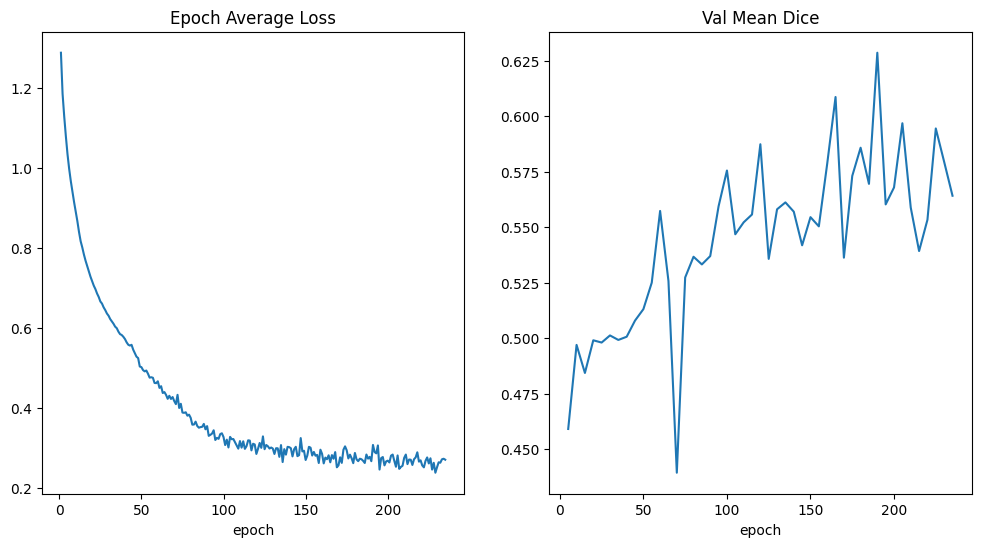

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

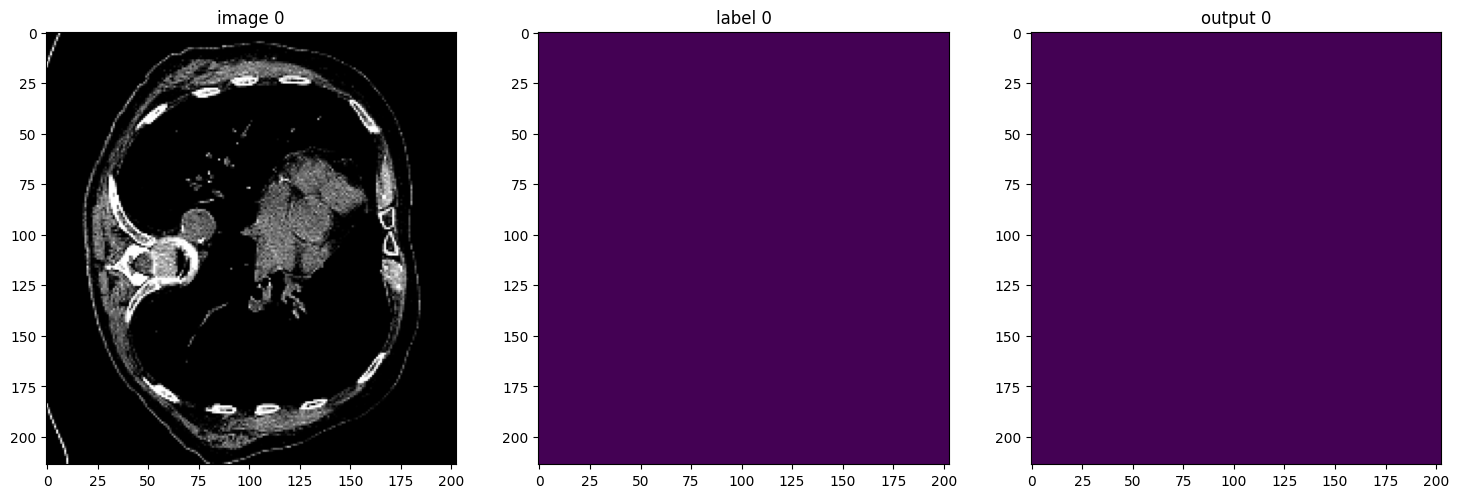

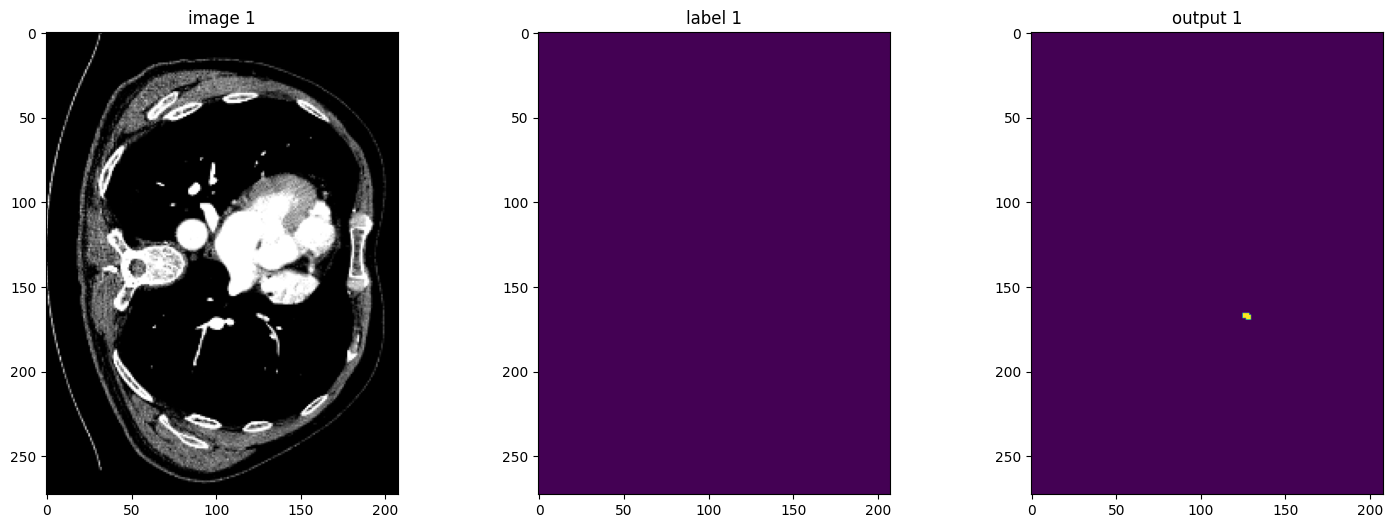

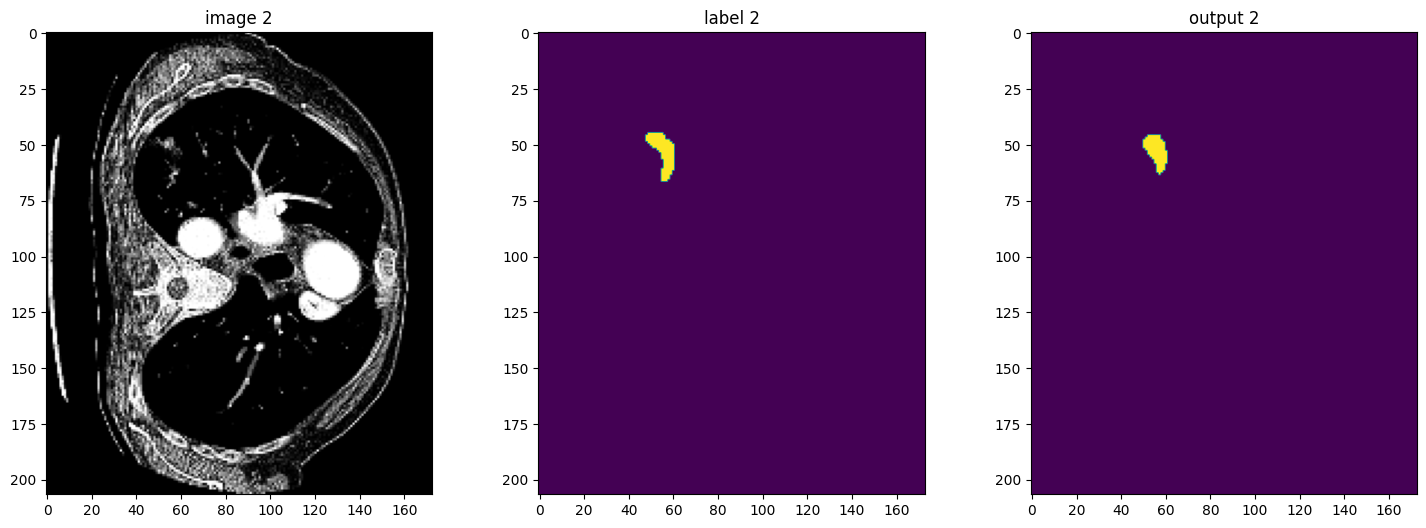

In [ ]:
model.load_state_dict(torch.load(os.path.join("./", "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        slice_idx = 90
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, slice_idx], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, slice_idx])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_idx])
        plt.show()
        if i == 2:
            break